
# MMF1921/MIE377 - Backtesting Template

The purpose of this program is to provide a template with which to develop Project 2. The project requires you to test different models  (and/or different model combinations) to create an asset management algorithm.

This template will be used by the instructor and TA to assess your trading algorithm using different datasets.

# PLEASE DO NOT MODIFY THIS TEMPLATE (for Project submission purposes)

# 1. Read input files

In [58]:
import numpy as np
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import time
import math
from scipy.stats import gmean,chi2
import matplotlib.pyplot as plt
from services.project_function import *
import pandas as pd
import itertools
from joblib import Parallel, delayed

adjClose = pd.read_csv("MMF1921_AssetPrices_3.csv", index_col=0)
factorRet = pd.read_csv("MMF1921_FactorReturns_3.csv", index_col=0)

In [60]:
adjClose.index = pd.to_datetime(adjClose.index)
factorRet.index = pd.to_datetime(factorRet.index)

In [61]:
# Initial budget to invest ($100,000)
initialVal = 100000

# Length of investment period (in months)
investPeriod = 6

factorRet = factorRet

#rf and factor returns
riskFree = factorRet['RF']
factorRet = factorRet.loc[:,factorRet.columns != 'RF'];


In [62]:
#Identify the tickers and the dates
tickers = adjClose.columns
dates   = factorRet.index

In [63]:
# Calculate the stocks monthly excess returns
# pct change and drop the first null observation
returns = adjClose.pct_change(1).iloc[1:, :]
returns = returns  - np.diag(riskFree.values) @ np.ones_like(returns.values)
# Align the price table to the asset and factor returns tables by discarding the first observation.
adjClose = adjClose.iloc[1:,:]

In [64]:
assert adjClose.index[0] == returns.index[0]
assert adjClose.index[0] == factorRet.index[0]

# 2. Run your program

This section will run your Project1_Function in a loop. The data will be loaded progressively as a growing window of historical observations.
Rebalancing will take place after every loop

In [65]:
# Start of out-of-sample test period
testStart = returns.index[0] + pd.offsets.DateOffset(years=5)

#End of the first investment period
testEnd = testStart + pd.offsets.DateOffset(months=investPeriod) -  pd.offsets.DateOffset(days = 1)

# End of calibration period
calEnd = testStart -  pd.offsets.DateOffset(days = 1)

# Total number of investment periods
NoPeriods = math.ceil((returns.index[-1].to_period('M') - testStart.to_period('M')).n / investPeriod)

# Number of assets
n  = len(tickers)

# Preallocate space for the portfolio weights (x0 will be used to calculate
# the turnover rate)
x  = np.zeros([n, NoPeriods])
x0 = np.zeros([n, NoPeriods])
insample_r2 = np.zeros([n, NoPeriods])

# Preallocate space for the portfolio per period value and turnover
currentVal = np.zeros([NoPeriods, 1])
turnover   = np.zeros([NoPeriods, 1])

#Initiate counter for the number of observations per investment period
toDay = 0

# Measure runtime: start the clock
start_time = time.time()

# Empty list to measure the value of the portfolio over the period
portfValue = []

for t in range(NoPeriods):
    # Subset the returns and factor returns corresponding to the current calibration period.
    periodReturns = returns[returns.index <= calEnd]
    periodFactRet = factorRet[factorRet.index <= calEnd]

    current_price_idx = (calEnd - pd.offsets.DateOffset(months=1) <= adjClose.index)&(adjClose.index <= calEnd)
    currentPrices = adjClose[current_price_idx]

    # Subset the prices corresponding to the current out-of-sample test period.
    periodPrices_idx = (testStart <= adjClose.index)&(adjClose.index <= testEnd)
    periodPrices = adjClose[periodPrices_idx]

    assert len(periodPrices) == investPeriod
    assert len(currentPrices) == 1
    # Set the initial value of the portfolio or update the portfolio value
    if t == 0:
        currentVal[0] = initialVal
        #Initial portfolio weights
        x0[:,0] = np.zeros(n)
    else:
        currentVal[t] = currentPrices @ NoShares.values.T
        #Store the current asset weights (before optimization takes place)
        x0[:,t] = currentPrices.values*NoShares.values/currentVal[t]

    #----------------------------------------------------------------------
    # Portfolio optimization
    # You must write code your own algorithmic trading function
    # The project function is in the services folder
    # Take in the period returns and period factor returns and produce
    # an allocation
    #----------------------------------------------------------------------
    objective_lambda_dict = {
        'portfolio_variance': 0,# this is fixed
        'turnover': 1,
        'ellipsoidal_robustness':chi2.ppf(0,n),
        'cvar':1,
        'cvar_alpha':0.95,
        'enet_lambda':0.1,
        'enet_alpha':0.95,
        'prediction_model':0
        # 'ellipsoidal_robustness':0,
    }
    x[:,t],insample_r2[:,t] = project_function(periodReturns, periodFactRet, x0[:,t], objective_lambda_dict)
    #Calculate the turnover rate
    if t > 0:
        turnover[t] = np.sum( np.abs( x[:,t] - x0[:,t] ) )

    # Number of shares your portfolio holds per stock
    NoShares = x[:,t]*currentVal[t]/currentPrices

    # Update counter for the number of observations per investment period
    fromDay = toDay
    toDay   = toDay + len(periodPrices)

    # Weekly portfolio value during the out-of-sample window
    portfValue.append(periodPrices@ NoShares.values.T)

    # Update your calibration and out-of-sample test periods
    testStart = testStart + pd.offsets.DateOffset(months=investPeriod)
    testEnd   = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days=1)
    calEnd    = testStart - pd.offsets.DateOffset(days=1)

portfValue = pd.concat(portfValue, axis = 0)
end_time = time.time()

# 3. Results

In [66]:
#--------------------------------------------------------------------------
# 3.1 Calculate the portfolio average return, standard deviation, Sharpe ratio and average turnover.
#-----------------------------------------------------------------------
# Calculate the observed portfolio returns
portfRets = portfValue.pct_change(1).iloc[1:,:]

# Calculate the portfolio excess returns
portfExRets = portfRets.subtract(riskFree[(riskFree.index >= portfRets.index[0])&(riskFree.index <= portfRets.index[-1])], axis = 0)

# Calculate the portfolio Sharpe ratio
SR = ((portfExRets + 1).apply(gmean, axis=0) - 1)/portfExRets.std()

# Calculate the average turnover rate
avgTurnover = np.mean(turnover[1:])

#Print Sharpe ratio and Avg. turnover to the console
print("Elasped time is "+ str(end_time - start_time) + ' seconds')
print('Sharpe ratio: ', str(SR[0]))
print('Avg. turnover: ', str(avgTurnover))
print('Composite Objective: ', str(0.8*SR[0] - 0.2*(avgTurnover**2+avgTurnover)))

Elasped time is 0.24160099029541016 seconds
Sharpe ratio:  0.1888680681164177
Avg. turnover:  0.013194501397667834
Composite Objective:  0.14842073524017402


In [67]:
np.mean(insample_r2)

0.36228538692446044

In [68]:
# OLS+MVO (TA BASELINE)
# Sharpe ratio:  0.1928084208916314
# Avg. turnover:  0.5500716823786466
# OLS + MVO + Turnover lambda 0.1
# Sharpe ratio:  0.13790566819371664
# Avg. turnover:  0.007992516576178615
# OLS + MVO + Turnover lambda 1
# Sharpe ratio:  0.13747055685427537
# Avg. turnover:  0.00787077194602842
# OLS + MVO + Turnover lambda 0.01
# Sharpe ratio:  0.14032916616142424
# Avg. turnover:  0.008263809342159065
# OLS + MVO + Turnover lambda 0.001 + Ellipsoidal Robustness 0.95
# Sharpe ratio:  0.19172738046836116
# Avg. turnover:  0.12507498439343978


<Figure size 640x480 with 0 Axes>

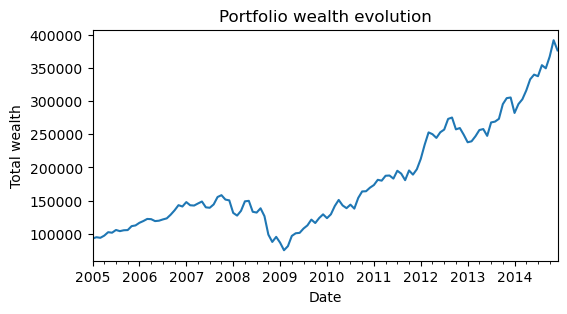

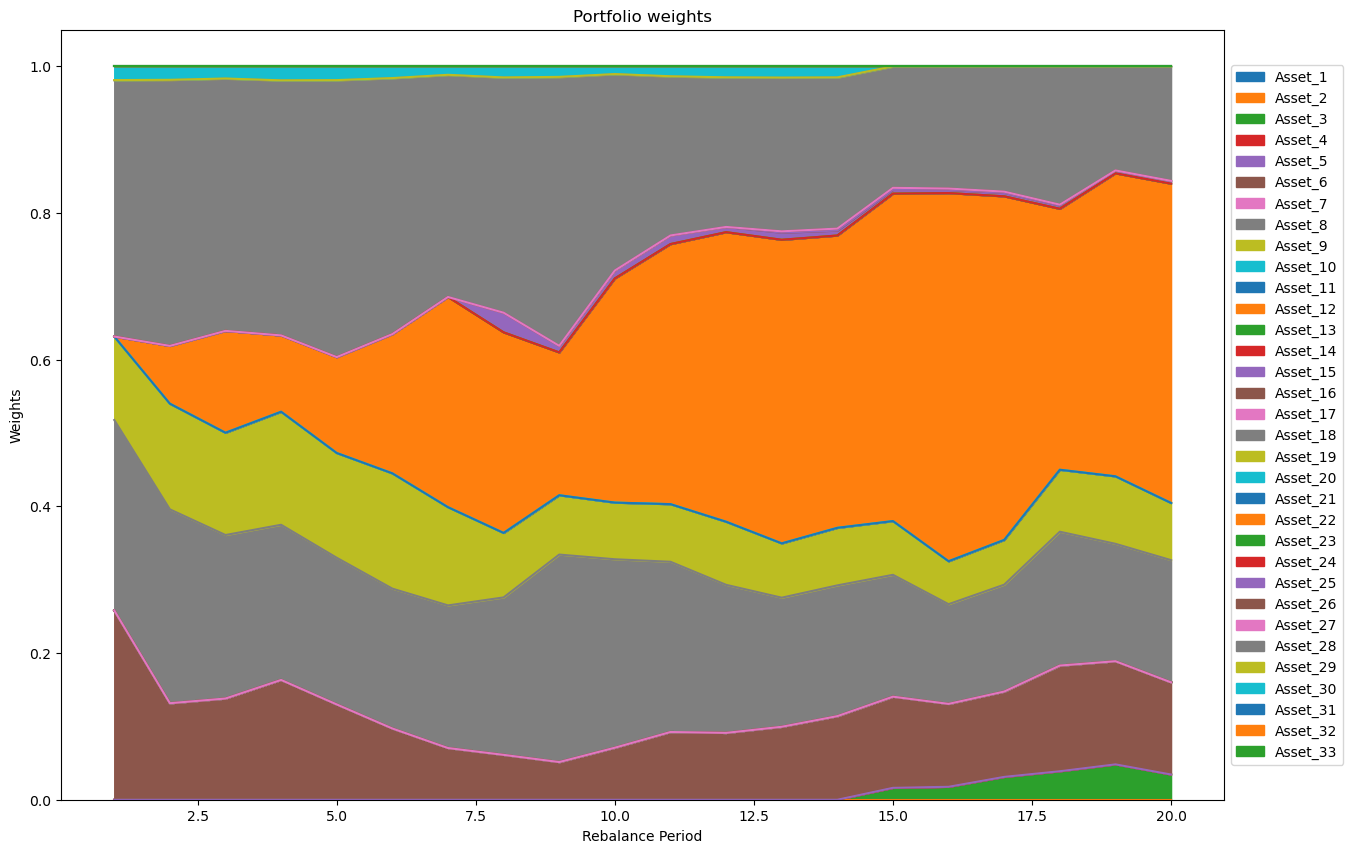

In [69]:
#--------------------------------------------------------------------------
# 3.2 Portfolio wealth evolution plot
#--------------------------------------------------------------------------
# Calculate the dates of the out-of-sample period

fig = plt.figure(1)
portfValue.plot(title = 'Portfolio wealth evolution',
                ylabel = 'Total wealth',
                figsize = (6, 3),
                legend = False)
plt.savefig("images/wealth.svg")

#--------------------------------------------------------------------------
# 3.3 Portfolio weights plot
#--------------------------------------------------------------------------
# Portfolio weights

fig2 = plt.figure(2)
x[x < 0] = 0
weights = pd.DataFrame(x, index = tickers)
weights.columns = [col + 1 for col in weights.columns]
weights[(weights > 0).any(axis=1)].T.plot.area(title = 'Portfolio weights',
                  ylabel = 'Weights', xlabel = 'Rebalance Period',
                  figsize = (6, 3),
                  legend = True, stacked = True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.gcf().set_size_inches(15, 10)
plt.savefig("images/weights.svg");
#
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# % Program End

In [70]:
import tqdm
# rewrite the loop to joblib
def run_portfolio(hp_set,model_param):
    # Start of out-of-sample test period
    testStart = returns.index[0] + pd.offsets.DateOffset(years=5)
    
    #End of the first investment period
    testEnd = testStart + pd.offsets.DateOffset(months=investPeriod) -  pd.offsets.DateOffset(days = 1)
    
    # End of calibration period
    calEnd = testStart -  pd.offsets.DateOffset(days = 1)
    
    # Total number of investment periods
    NoPeriods = math.ceil((returns.index[-1].to_period('M') - testStart.to_period('M')).n / investPeriod)
    
    # Number of assets
    n  = len(tickers)
    if model_param >0:
        objective_lambda_dict = {
            'portfolio_variance': hp_set[0],
            'turnover': hp_set[1],
            'ellipsoidal_robustness':chi2.ppf(hp_set[2],n),
            'cvar':hp_set[3],
            'cvar_alpha':hp_set[4],
            'enet_lambda': hp_set[5],
            'enet_alpha': hp_set[6],
            'prediction_model':model_param
        }
    else:
        objective_lambda_dict = {
            'portfolio_variance': hp_set[0],
            'turnover': hp_set[1],
            'ellipsoidal_robustness':chi2.ppf(hp_set[2],n),
            'cvar':hp_set[3],
            'cvar_alpha':hp_set[4],
            'enet_lambda': 0,
            'enet_alpha': 0,
            'prediction_model':model_param
        }
    
    # Preallocate space for the portfolio weights (x0 will be used to calculate
    # the turnover rate)
    x  = np.zeros([n, NoPeriods])
    x0 = np.zeros([n, NoPeriods])
    insample_r2 = np.zeros([n, NoPeriods])
    
    # Preallocate space for the portfolio per period value and turnover
    currentVal = np.zeros([NoPeriods, 1])
    turnover   = np.zeros([NoPeriods, 1])
    
    #Initiate counter for the number of observations per investment period
    toDay = 0
    
    # Measure runtime: start the clock
    # start_time = time.time()
    
    # Empty list to measure the value of the portfolio over the period
    portfValue = []
    
    for t in range(NoPeriods):
        # Subset the returns and factor returns corresponding to the current calibration period.
        periodReturns = returns[returns.index <= calEnd]
        periodFactRet = factorRet[factorRet.index <= calEnd]
    
        current_price_idx = (calEnd - pd.offsets.DateOffset(months=1) <= adjClose.index)&(adjClose.index <= calEnd)
        currentPrices = adjClose[current_price_idx]
    
        # Subset the prices corresponding to the current out-of-sample test period.
        periodPrices_idx = (testStart <= adjClose.index)&(adjClose.index <= testEnd)
        periodPrices = adjClose[periodPrices_idx]
    
        assert len(periodPrices) == investPeriod
        assert len(currentPrices) == 1
        # Set the initial value of the portfolio or update the portfolio value
        if t == 0:
            currentVal[0] = initialVal
            #Initial portfolio weights
            x0[:,0] = np.zeros(n)
        else:
            currentVal[t] = currentPrices @ NoShares.values.T
            #Store the current asset weights (before optimization takes place)
            x0[:,t] = currentPrices.values*NoShares.values/currentVal[t]
    
        #----------------------------------------------------------------------
        # Portfolio optimization
        # You must write code your own algorithmic trading function
        # The project function is in the services folder
        # Take in the period returns and period factor returns and produce
        # an allocation
        #----------------------------------------------------------------------
        
        x[:,t],insample_r2[:,t] = project_function(periodReturns, periodFactRet, x0[:,t], objective_lambda_dict)
        #Calculate the turnover rate
        if t > 0:
            turnover[t] = np.sum( np.abs( x[:,t] - x0[:,t] ) )
    
        # Number of shares your portfolio holds per stock
        NoShares = x[:,t]*currentVal[t]/currentPrices
    
        # Update counter for the number of observations per investment period
        fromDay = toDay
        toDay   = toDay + len(periodPrices)
    
        # Weekly portfolio value during the out-of-sample window
        portfValue.append(periodPrices@ NoShares.values.T)
    
        # Update your calibration and out-of-sample test periods
        testStart = testStart + pd.offsets.DateOffset(months=investPeriod)
        testEnd   = testStart + pd.offsets.DateOffset(months=investPeriod) - pd.offsets.DateOffset(days=1)
        calEnd    = testStart - pd.offsets.DateOffset(days=1)
    
    portfValue = pd.concat(portfValue, axis = 0)
    # end_time = time.time()
    # Calculate the observed portfolio returns
    portfRets = portfValue.pct_change(1).iloc[1:,:]
    
    # Calculate the portfolio excess returns
    portfExRets = portfRets.subtract(riskFree[(riskFree.index >= portfRets.index[0])&(riskFree.index <= portfRets.index[-1])], axis = 0)
    
    # Calculate the portfolio Sharpe ratio
    portfolio_gmean = ((portfExRets + 1).apply(gmean, axis=0) - 1)
    SR = portfolio_gmean/portfExRets.std()
    
    # Calculate the average turnover rate
    avgTurnover = np.mean(turnover[1:])
    portfolio_stats = {key:value for key,value in zip(['mvo_lambda', 'turnover_lambda', 'ellipsoidal_robustness', 'cvar_lambda', 'cvar_alpha', 'enet_lambda', 'enet_alpha', 'ENET_prediction_model'],hp_set)}
    portfolio_stats['6 Month Excess Return'] = portfolio_gmean[0]
    portfolio_stats['6 Month Sharpe_ratio'] = SR[0]
    portfolio_stats['6 Month Avg_turnover'] = avgTurnover
    portfolio_stats['6 Month Composite_Objective'] = 0.8*SR[0] - 0.2*avgTurnover
    portfolio_stats['Avg Insample_R2'] = np.mean(insample_r2)
    portfolio_stats['Avg Deviation from 1/n'] = np.abs((x-1/n)).mean()
    return portfolio_stats

In [71]:

# objective_lambda_dict = {
#         'portfolio_variance': 1,# this is fixed
#         'turnover': 0.01,
#         'ellipsoidal_robustness':chi2.ppf(0.95,n),
#         'cvar':0.1,
#         'cvar_alpha':0.95,
#         'enet_lambda':0.1,
#         'enet_alpha':0.95,
#         'prediction_model':1
#         # 'ellipsoidal_robustness':0,
#     }
mvo_lambda = np.linspace(0,1,5)
turnover_lambda = np.linspace(0,1,5)
ellipsoidal_robustness = np.linspace(0.85,0.99,5)
cvar_lambda = np.linspace(0,1,5)
cvar_alpha = np.linspace(0.85,0.99,5)
enet_lambda = np.linspace(-1,1,5)
enet_alpha = np.linspace(0,1,5)
# search space 5**7+5**5=81250
# estimated time: 20 items per second, 156250/20 = 4062.5 seconds = 67.7 minutes = 1.128 hours

In [ ]:
ENET_portfolio_stats = Parallel(n_jobs=-1)(delayed(run_portfolio)(hp_set,1) for hp_set in tqdm.tqdm(itertools.product(mvo_lambda,turnover_lambda,ellipsoidal_robustness,cvar_lambda,cvar_alpha,enet_lambda,enet_alpha)))


0it [00:00, ?it/s]
22it [00:00, 183.67it/s]
44it [00:04,  8.69it/s] 
66it [00:05, 11.48it/s]
88it [00:06, 13.57it/s]
110it [00:08, 14.52it/s]
132it [00:09, 16.11it/s]
154it [00:10, 16.71it/s]
176it [00:11, 17.08it/s]
198it [00:13, 16.25it/s]
220it [00:14, 16.48it/s]
242it [00:15, 16.40it/s]
264it [00:17, 16.34it/s]
286it [00:18, 16.42it/s]
308it [00:19, 17.52it/s]
330it [00:20, 17.33it/s]
352it [00:22, 16.51it/s]
374it [00:23, 16.58it/s]
396it [00:24, 16.50it/s]
418it [00:26, 16.20it/s]
440it [00:27, 15.99it/s]
462it [00:29, 15.07it/s]
484it [00:31, 14.39it/s]
506it [00:32, 14.50it/s]
528it [00:33, 14.80it/s]
550it [00:35, 14.02it/s]
572it [00:37, 13.84it/s]
594it [00:39, 13.64it/s]
616it [00:41, 12.68it/s]
638it [00:42, 12.75it/s]
660it [00:44, 13.03it/s]
682it [00:45, 14.13it/s]
704it [00:47, 13.82it/s]
726it [00:48, 13.62it/s]
748it [00:50, 13.69it/s]
770it [00:52, 13.26it/s]
792it [00:54, 13.04it/s]
814it [00:55, 12.99it/s]
836it [00:57, 13.09it/s]
858it [00:59, 12.88it/s]
880it [

In [ ]:
OLS_portfolio_stoptats = Parallel(n_jobs=-1)(delayed(run_portfolio)(hp_set,0) for hp_set in tqdm.tqdm(itertools.product(mvo_lambda,turnover_lambda,ellipsoidal_robustness,cvar_lambda,cvar_alpha)))

In [ ]:
ENET_portfolio_stats_df = pd.DataFrame(ENET_portfolio_stats).to_csv('ENET_portfolio_stats_ret_constraint.csv')
OLS_portfolio_stats_df = pd.DataFrame(OLS_portfolio_stats).to_csv('OLS_portfolio_stats_ret_constraint.csv')